<a href="https://colab.research.google.com/github/nicolas998/WMF/blob/ghos_topo/Ghost_using_EE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install packages

In [1]:
!apt-get install -qq libgdal-dev libproj-dev
!pip install cartopy
!pip install netCDF4
!pip install rasterio
!pip install git+https://github.com/nicolas998/WMF.git@ghos_topo --upgrade
!pip install pysheds
!pip install geopandas 
!pip install geemap

  Cloning https://github.com/nicolas998/WMF.git (to revision ghos_topo) to /tmp/pip-req-build-fqrlmoll
  Running command git clone -q https://github.com/nicolas998/WMF.git /tmp/pip-req-build-fqrlmoll
  Running command git checkout -b ghos_topo --track origin/ghos_topo
  Switched to a new branch 'ghos_topo'
  Branch 'ghos_topo' set up to track remote branch 'ghos_topo' from 'origin'.
  Created wheel for wmf: filename=wmf-1.1-cp37-cp37m-linux_x86_64.whl size=630441 sha256=5c42218864d4a8188b54ab33d359a1dabc2032c2ab9f5c498318d0967edd4504
  Stored in directory: /tmp/pip-ephem-wheel-cache-2e4gtehn/wheels/8c/e7/ab/9b2ff844fb0371d8fc2083cb3e45d40f9e9b694aa9e3203385
Successfully built wmf
  Found existing installation: wmf 1.1
    Uninstalling wmf-1.1:
      Successfully uninstalled wmf-1.1


In [2]:
import pylab as pl 
from wmf import wmf 
import numpy as np 
import pandas as pd 
import os
import osgeo
from wmf import ghost_topo as go 
import ee
import folium
import geopandas as geop
import warnings
warnings.filterwarnings('ignore')

No se logra importar deap tools, por lo tanto se deshabilita SimuBasin.Calib_NSGAII
To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=bw3TZ_ZF7FBRWLYt66WdKYGGlF_6Cj9KNjU2DnaVjTI&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g61x-f54srlgugv_n_g2iRi5ZNQrb1Zacbzi_BbRIzsjGVddkxeY0Q

Successfully saved authorization token.


# Set up a watershed 

## Read and process DEM 

In [3]:
DEM, DIR,epsg  = wmf.dem_process('/content/drive/MyDrive/IIHR/2021_IWA/data/dem.tif', dxp = 96, noData = -9999)

1. DEM raster readed
2. DEM depressions filled
3. DEM corrected
4. DIR map derived
5. Finish!


## Extract watershed

In [4]:
st = wmf.Stream(352378,4605633, DEM, DIR)
cu = wmf.SimuBasin(340517,4589890, DEM, DIR, stream=st, threshold=50)

1


## Get ghost class and its elements

In [5]:
gp = go.ghost_preprocess(cu, path_dem='/content/drive/MyDrive/IIHR/2021_IWA/data/dem.tif', 
    seg_threshold=700,
    seg_point_distance=75)

corrected = gp.get_segments_topology(epsilon=0.1)
gp.get_mesh_river_points(clean_close_points=True,
                         min_river2river_distance=50)
gp.get_mesh_grid_points(mesh_spaces=5,
                        border_iter=4,
                        clean_with_river=True,
                        min_dem2river_distance=50)

gp.get_voronoi_polygons()
gp.define_polygons_topology()

# Use earth explorer functions to set up the soil properties

In [6]:
gp.write_mesh_file('/content/drive/MyDrive/IIHR/2021_IWA/data/mesh.mesh','/content/drive/MyDrive/IIHR/2021_IWA/data/mesh.shp')

In [7]:
data = go.get_soils_data()
gp.get_physical_prop(data, prop_name='soils')

In [8]:
gp.polygons_shp

,polygon,area[m2],z[m],nfaces,geometry,soils
0,1,63136.789673,363.152206,5,"POLYGON ((340496.385 4590466.772, 340873.595 4...",5.0
1,2,123059.175171,363.387451,7,"POLYGON ((340552.789 4590641.500, 340576.518 4...",5.0
2,3,58271.146484,364.064880,4,"POLYGON ((341385.660 4590391.004, 341125.717 4...",8.0
3,4,45806.885620,364.779419,5,"POLYGON ((341764.706 4590622.827, 341600.985 4...",8.0
4,5,60503.160889,365.442841,6,"POLYGON ((341776.067 4590096.305, 341750.203 4...",5.0
...,...,...,...,...,...,...
2385,2386,262754.893555,423.937088,9,"POLYGON ((362003.328 4610078.500, 362103.757 4...",5.0
2386,2387,242811.600708,433.160675,9,"POLYGON ((361867.894 4609054.606, 361631.952 4...",5.0
2387,2388,152327.759644,443.068481,8,"POLYGON ((361925.565 4600222.065, 361925.682 4...",8.0
2388,2389,179779.618896,453.776596,10,"POLYGON ((361580.260 4599410.634, 361521.109 4...",5.0


# Use of the properties function in google colab 

In [9]:
data = go.get_soils_data()

In [8]:
gp.get_physical_prop()

# Get Earth Engine data 

In [6]:
# Trigger the authentication flow.
ee.Authenticate()
# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=dnnCMXVMU1Nv8ERZ3Td4Jna5w5bNKlWVJdCy0E-mwm4&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g5GnanqMx_mALFncqCm4AXib4pZ56Yshoh07YB8IXI2g1PNTxKpnqo

Successfully saved authorization token.


## Resample soil data to the polygons 

In [7]:
# Convert the boundary of the watershed to an ee feature 
cu.Save_Basin2Map('/content/drive/MyDrive/IIHR/2021_IWA/data/divisory.shp', EPSG=int(cu.epsg))
shapefile = geop.read_file('/content/drive/MyDrive/IIHR/2021_IWA/data/divisory.shp')
shapefile.to_crs(4326, inplace = True)
boundary = ee.Feature(eval(shapefile.iloc[0:1].to_json())['features'][0])
xc = shapefile.centroid.x[0]
yc = shapefile.centroid.y[0]

#Get the polygons in ee
gp.write_mesh_file('/content/drive/MyDrive/IIHR/2021_IWA/data/mesh.mesh','/content/drive/MyDrive/IIHR/2021_IWA/data/mesh.shp')
shapefile = geop.read_file('/content/drive/MyDrive/IIHR/2021_IWA/data/mesh.shp')
shapefile.to_crs(4326, inplace = True)
features = []
for i in range(shapefile.shape[0]):
    geom = shapefile.iloc[i:i+1,:] 
    jsonDict = eval(geom.to_json()) 
    geojsonDict = jsonDict['features'][0] 
    features.append(ee.Feature(geojsonDict)) 
polygons = ee.FeatureCollection(features)

In [18]:
def shp2ee(path_shp, type = 'single'):
  '''Converts a shapefile to an ee Feature or collection of Features.
  Parameters:
    - path_shp: path to the shapefile to convert.
    - type:
        - single: if the vector has only one feature.
        - multiple: if the vector has multiple features
  Returns:
    - ee.Feature for type single or ee.FeatureCollection for type multiple'''
  #Read the polygon into geopandas
  shapefile = geop.read_file(path_shp)
  shapefile.to_crs(4326, inplace = True)
  
  #If single, returns just one ee feature
  if type == 'single':
    return ee.Feature(eval(shapefile.iloc[0:1].to_json())['features'][0])
  #If multiple, returns just an ee collection of features
  elif type == 'multiple':
    features = []
    for i in range(shapefile.shape[0]):
        geom = shapefile.iloc[i:i+1,:] 
        jsonDict = eval(geom.to_json()) 
        geojsonDict = jsonDict['features'][0] 
        features.append(ee.Feature(geojsonDict)) 
    return ee.FeatureCollection(features)



In [17]:
boundary = shp2ee('/content/drive/MyDrive/IIHR/2021_IWA/data/divisory.shp')
polygons = shp2ee('/content/drive/MyDrive/IIHR/2021_IWA/data/mesh.shp', type='multiple')

In [15]:
# Read the data and clip it with the watershed of interest
data = ee.Image('OpenLandMap/SOL/SOL_TEXTURE-CLASS_USDA-TT_M/v02')


In [ ]:
land_use = ee.Image('USDA/NASS/CDL')

In [19]:
def get_physical_properties(ee_data, boundary, poly_mesh, scale = 30, prop_name = 'feature',band = 'b0'):
  '''Assigns ee_data to the elements in the poly_mesh
  Parameters:
    - ee_data: an Earth Engine image object.
    - boundary: an ee.Feature describing the watershed divisory
    - poly_mesh: an ee.FeatureCollection describing the polygons
    - prop_name: name to assign to the property in the shapefile of polygons'''
  #Clip the data to the boundary
  data_c = ee_data.clip(boundary)
  #Get the soils information for each polygon 
  d = data_c.reduceRegions(poly_mesh, reducer = ee.Reducer.mode(), scale = scale).getInfo()
  soils = []
  for i in range(shapefile.shape[0]):
    soils.append(d['features'][i]['properties']['b0'])
  shapefile[prop_name] = soils

In [25]:
#Clip the data to the boundary
#data_c = ee_data.clip(boundary)
#Get the soils information for each polygon 
d = data.reduceRegions(polygons, reducer = ee.Reducer.mode(), scale = 30).getInfo()
soils = []
for i in range(shapefile.shape[0]):
  soils.append(d['features'][i]['properties']['b0'])
shapefile['soils'] = soils

In [ ]:
shapefile.to_file('/content/drive/MyDrive/IIHR/2021_IWA/data/mesh_soil.shp')

In [20]:
shapefile

,polygon,area[m2],z[m],nfaces,geometry,soil_texture
0,1,63136.789673,363.152206,5,"POLYGON ((-94.90956 41.44994, -94.90496 41.447...",5.0
1,2,123059.175171,363.387451,7,"POLYGON ((-94.90893 41.45153, -94.90866 41.451...",5.0
2,3,58271.146484,364.064880,4,"POLYGON ((-94.89890 41.44944, -94.90198 41.448...",8.0
3,4,45806.885620,364.779419,5,"POLYGON ((-94.89443 41.45160, -94.89636 41.450...",8.0
4,5,60503.160889,365.442841,6,"POLYGON ((-94.89415 41.44686, -94.89444 41.446...",5.0
...,...,...,...,...,...,...
2385,2386,262754.893555,423.937088,9,"POLYGON ((-94.65669 41.63050, -94.65547 41.629...",5.0
2386,2387,242811.600708,433.160675,9,"POLYGON ((-94.65808 41.62126, -94.66090 41.620...",5.0
2387,2388,152327.759644,443.068481,8,"POLYGON ((-94.65536 41.54175, -94.65534 41.541...",8.0
2388,2389,179779.618896,453.776596,10,"POLYGON ((-94.65931 41.53438, -94.66003 41.534...",5.0


In [ ]:
# Define a method for displaying Earth Engine image tiles to folium map.
def Mapdisplay(center, dicc, Tiles="OpensTreetMap",zoom_start=10):
    '''
    :param center: Center of the map (Latitude and Longitude).
    :param dicc: Earth Engine Geometries or Tiles dictionary
    :param Tiles: Mapbox Bright,Mapbox Control Room,Stamen Terrain,Stamen Toner,stamenwatercolor,cartodbpositron.
    :zoom_start: Initial zoom level for the map.
    :return: A folium.Map object.
    '''
    mapViz = folium.Map(location=center,tiles=Tiles, zoom_start=zoom_start)
    for k,v in dicc.items():
      if ee.image.Image in [type(x) for x in v.values()]:        
        folium.TileLayer(
            tiles = v["tile_fetcher"].url_format,
            attr  = 'Google Earth Engine',
            overlay =True,
            name  = k
          ).add_to(mapViz)
      else:        
        folium.GeoJson(
        data = v,
        name = k
          ).add_to(mapViz)
    mapViz.add_child(folium.LayerControl())
    return mapViz

def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

# Set visualization parameters.
vis_params = {
  'bands':['b10'],
  'min': 0,
  'max': 12,
  'palette': ["d5c36b","b96947","9d3706","ae868f","f86714","46d143",
    "368f20","3e5a14","ffd557","fff72e","ff5a9d","ff005b",]}

# Create a folium map object.
my_map = folium.Map(location=[yc, xc], zoom_start=10)

# Add the elevation model to the map object.
#my_map.add_ee_layer(data.updateMask(data.gt(0)), vis_params, 'soil_texture')
my_map.add_ee_layer(data_c, vis_params, 'soil_texture')
#my_map.add_ee_layer(fc.getInfo(), {}, 'divisory')
folium.GeoJson(
        data = boundary.getInfo(),
        name = 'divisory'
          ).add_to(my_map)
# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)

In [ ]:

pts = geop.GeoDataFrame(np.arange(1,gp.mesh_points_all.shape[0]+1), geometry=geop.points_from_xy(gp.mesh_points_all.T[0], gp.mesh_points_all.T[1]), crs='EPSG:'+cu.epsg)
pts = pts.to_crs(4326)
xy = ee.Geometry.Point([pts['geometry'][0].coords.xy[0][0],pts['geometry'][0].coords.xy[1][0]], proj = 'EPSG:4326')
ee_pts = ee.Geometry.MultiPoint([pts.geometry.values.x.tolist(), pts.geometry.values.y.tolist()], proj = 'EPSG:4326')

In [ ]:
6.25*4*600

15000.0

In [ ]:
20*11*(12**2)

31680

In [ ]:
features = []
for i in range(shapefile.shape[0]):
    geom = shapefile.iloc[i:i+1,:] 
    jsonDict = eval(geom.to_json()) 
    geojsonDict = jsonDict['features'][0] 
    features.append(ee.Feature(geojsonDict)) 

fc = ee.FeatureCollection(features)


In [ ]:
poly = ee.Geometry.Polygon([[[pts.geometry.values.x.min(),pts.geometry.values.y.min()],
[pts.geometry.values.x.min(),pts.geometry.values.y.max()],
[pts.geometry.values.x.max(),pts.geometry.values.y.max()],
[pts.geometry.values.x.max(),pts.geometry.values.y.min()]]])


In [ ]:
soils = []
for x, y in zip(pts.geometry.values.x.tolist(), pts.geometry.values.y.tolist()):
  xy = ee.Geometry.Point([x, y])
  soils.append(data.sample(xy,1).first().get('b0').getInfo())

In [ ]:
sample = data.sampleRegions(ee_pts).first().get('b0')

In [ ]:
sample.serialize()

'{"result": "0", "values": {"0": {"functionInvocationValue": {"functionName": "Element.get", "arguments": {"object": {"functionInvocationValue": {"functionName": "Collection.first", "arguments": {"collection": {"functionInvocationValue": {"functionName": "Image.sampleRegions", "arguments": {"collection": {"functionInvocationValue": {"functionName": "Collection", "arguments": {"features": {"arrayValue": {"values": [{"functionInvocationValue": {"functionName": "Feature", "arguments": {"geometry": {"functionInvocationValue": {"functionName": "GeometryConstructors.MultiPoint", "arguments": {"coordinates": {"constantValue": [[-94.9069887127806, -94.9052227927273, -94.90128283462415, -94.89624740445547, -94.89636428674271, -94.8921388201789, -94.88521559321757, -94.87783635570577, -94.89556301556418, -94.89428794949788, -94.89679394480598, -94.89626928439566, -94.89380035542327, -94.89296477766776, -94.89880191347261, -94.9015710205719, -94.89832456346413, -94.90377937645212, -94.88737965620

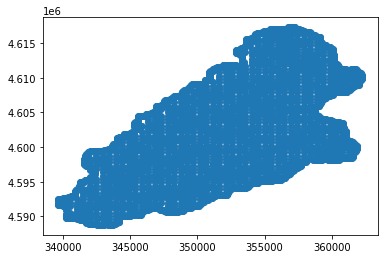

In [ ]:
pl.scatter(gp.mesh_points_all.T[0], gp.mesh_points_all.T[1],)

In [ ]:
cu.Polygon


array([[ 357084.7182312 ,  357084.7182312 ,  356795.38783264, ...,
         357374.04862976,  357374.04862976,  357084.7182312 ],
       [4617215.37905884, 4616926.04866028, 4616926.04866028, ...,
        4617022.49212646, 4617215.37905884, 4617215.37905884]])

In [ ]:
len(gp.polygons_xy)

2390